# Augmenting with Noise Textures

## Introduction: Deep Learning Denoising
Deep convolutional neural networks (CNNs) have been shown to be effective for [CT denoising applications](https://pubs.rsna.org/doi/abs/10.1148/rg.2021200196) powerful tools for removing noise from CT images and are already being used clinically, both in vendor specific implementations:

| Product          | 510(k) Summary | Assessment | Type | Vendor Specific|
|------------------|:----------:|----------------|------|----------------|
| [Canon AiCE](https://global.medical.canon/products/computed-tomography/aice)|[K192832](https://www.accessdata.fda.gov/cdrh_docs/pdf19/K192832.pdf)|[Brady et al 2021](https://pubs.rsna.org/doi/full/10.1148/radiol.2020202317)|Image Based|Yes|
| [GE True Fidelity DLIR](https://www.gehealthcare.com/products/truefidelity)|[K201745](https://www.accessdata.fda.gov/cdrh_docs/pdf20/K201745.pdf)|[Noda et al 2021](https://doi.org/10.1007/s00261-021-03111-x)| Image Based     | Yes |
| United Imaging Deep Recon| [K193073](https://www.accessdata.fda.gov/cdrh_docs/pdf19/K193073.pdf) | | Image Based | Yes |
| [Philips Precise Image](https://www.philips.com/c-dam/b2bhc/master/resource-catalog/landing/precise-suite/incisive_precise_image.pdf) | [K210760](https://www.accessdata.fda.gov/cdrh_docs/pdf21/K210760.pdf) | | Image Based | Yes |
| [Claripi ClariCT](https://www.claripi.com/clarict-ai/)      | [K183460](https://www.accessdata.fda.gov/cdrh_docs/pdf18/K183460.pdf)|  | Image Based | No |

## Deep Learning Denoisers Learn Image Textures
However, despite deep learning's flexibility to learn challenging computer vision tasks from data, these models are known to not generalize well to data characteristically different than they were trained on. This was shown by a deep learning pneumonia detection model that performed well on internal data, more similar to its training set, than on external data where performance droped [Zech et al., 2018](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002683). Specifically, deep denoising algorithms - often based on deep recurrent layers of convolutions (See [Chen et al 2017]()) - have been shown learn specific frequencies of noise texture via training. [Zeng et al 2022](http://onlinelibrary.wiley.com/doi/abs/10.1002/mp.15430) showed this by testing deep denoisers on sharp kernel test sets after training the models on smooth kernel training data. The noise power spectra of the denoised images revealed that only noise power in the lower spatial frequencies encountered in the training data were removed, leaving the higer frequencies largely untouched.

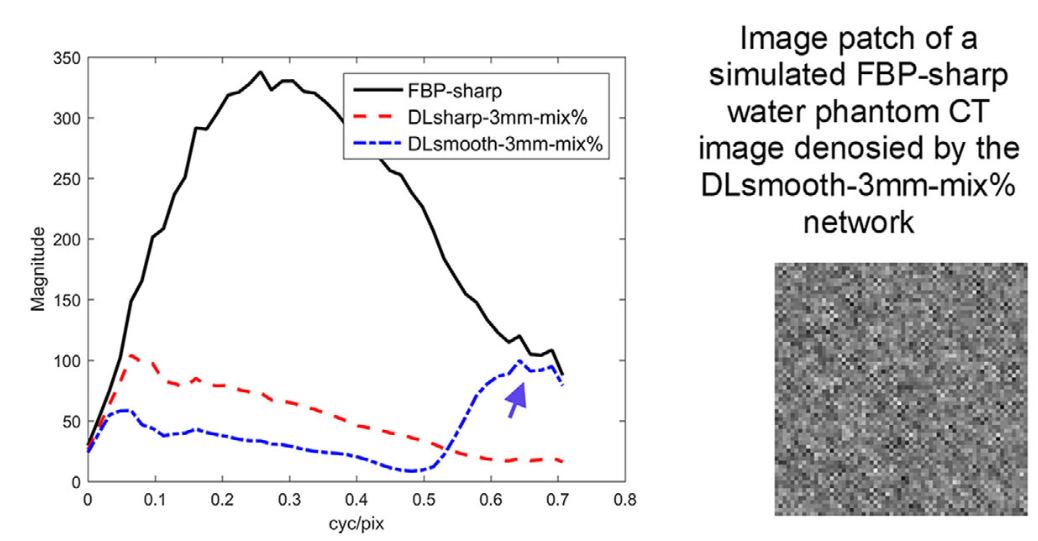

From Figure 8 of [Zeng et al 2022](http://onlinelibrary.wiley.com/doi/abs/10.1002/mp.15430)

## Impact on Pediatric Populations



See also [ITK's discussion of Data Augmentation for Machine Learning](https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/70_Data_Augmentation.html)
- to be sure that we are helping rather than hurting we need to ensure that our augmentations are representative of the natural variability in our intended population, here pediatric patients. We will do this in two ways:
1. study the noise power spectra of pediatric patient images, generated via simulation using the XCAT phantoms
2. assess whether this noise power can be reproduced by equal sized water phantoms

Step 2 is of practical importance as being able to make these experiments using physical phantoms is an important consideration for making these conclusions usable in the real world where we cannot peform multiple acquisitions on patients.

## Noise Texture from Pediatric CT Simulations
- TODO

## Noise Texture from Pediatric-Sized Water Phantom Simulations

Noise statistically can be described in terms of its intensity content and its spatial content.

- Intensity content can be described using histograms to describe the distribution of pixel intensities that can be summarized by a mean (ideally around 0) and standard deviation, which describes the noise magnitude.
- Spatial content can be described using noise power spectra which uses Fourier analysis to quantify how much noise content exists at different spatial frequencies, where white noise (aka uncorrelated noise) is uniform across all frequencies, whereas more common in CT, noise is related to the spatial resolution of the system and thus is correlated leading to lower frequency peak that attenuates at higher frequencies due to the apodizing filter used in CT reconstruction (Cite links to learn more).

Before studying the noise in the out-of-distribution pediatric patients, we first want to establish a baseline of the noise properties used to train the deep denoiser, here trained on the [Mayo Clinic Low Dose Grand Challenge Dataset](https://aapm.onlinelibrary.wiley.com/doi/full/10.1002/mp.12345)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

save_path = '/gpfs_projects/brandon.nelson/Mayo_LDGC/numpy_files'
npfiles = glob(save_path+'/*.npy')

/gpfs_projects/brandon.nelson/Mayo_LDGC/numpy_files/L291_249_target.npy


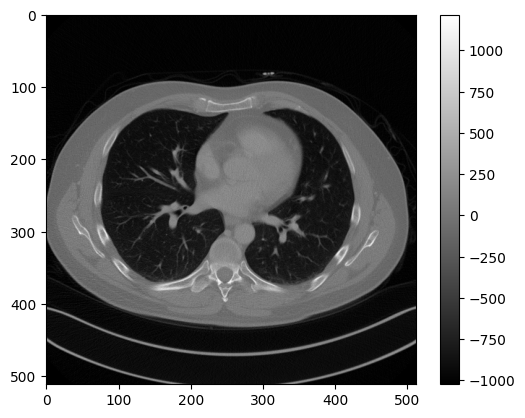

In [2]:
img = np.load(npfiles[0])
print(npfiles[0])
plt.imshow(img, cmap='gray')
plt.colorbar()

[Using ITK Widgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

pip install 'itkwidgets[lab]>=1.0a23'

pip install pyimagej

In [3]:
# from itkwidgets import view

# view(img)

In [4]:
img.std()

464.6921933268496

Text(0.5, 1.0, 'mean: 63.74 | std: 99.96')

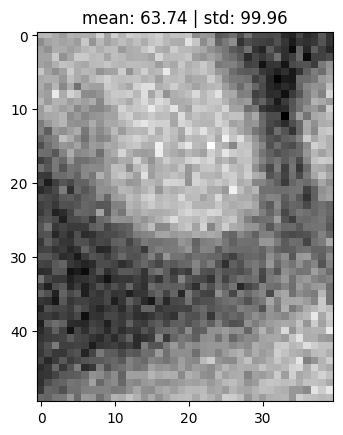

In [5]:
subimg = img[200:250, 210:250]
plt.imshow(subimg, cmap='gray')
plt.title(f'mean: {subimg.mean():0.2f} | std: {subimg.std():0.2f}')

These stds seem high, check with the L

Note that the training images have been normalized from [-1024, 3072] to [0, 0.5]

Update: normalization removed, should be native [-1024, 3072]

### Check that the dataloader is working as expected

In [6]:
import sys
sys.path.append('../denoising')
from loader import get_loader
get_loader?

Signature:
get_loader(
    mode='train',
    load_mode=0,
    saved_path=None,
    test_patient='L506',
    patch_n=None,
    patch_size=None,
    transform=None,
    batch_size=32,
    num_workers=6,
)
Docstring: <no docstring>
File:      ~/Dev/PediatricCTSizeAugmentation/denoising/loader.py
Type:      function

In [7]:
np_path = '/gpfs_projects/brandon.nelson/Mayo_LDGC/numpy_files'
train_dl = get_loader(mode='train', saved_path=np_path, patch_size=64, patch_n=10)

In [8]:
i = 0
for x, y in train_dl:
    i += 1
    if i > 0:
        break
x.shape, y.shape

(torch.Size([32, 10, 64, 64]), torch.Size([32, 10, 64, 64]))

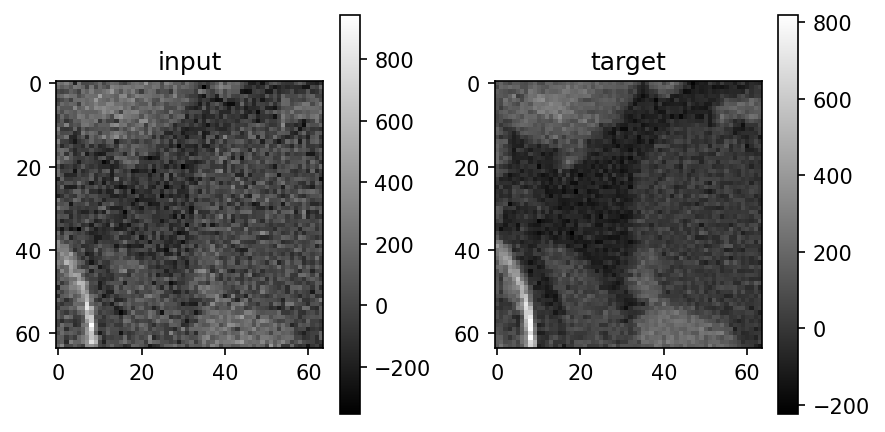

In [9]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(6,3), dpi=150)
ax = plt.subplot(1,2,1)
im = ax.imshow(x[0, 0], cmap='gray')
plt.title('input')
plt.colorbar(im)
ax = plt.subplot(1,2, 2)
im = ax.imshow(y[0, 0], cmap='gray')
plt.colorbar(im)
plt.title('target')
plt.tight_layout()

### See how the training data histograms compare to the processed training data files and test data

In [10]:
from pathlib import Path

In [11]:
img_path = Path('/gpfs_projects/brandon.nelson/Mayo_LDGC/images')
raw_images = list((img_path/'L506').rglob('*.IMA')) #L506 the test case

input_images = [f for f in raw_images if 'quarter_3mm' in str(f)]
target_images = [f for f in raw_images if f not in input_images]
input_images.sort()
target_images.sort()

import pydicom
import numpy as np

image_list = []

for fname in input_images:
  dcm_file = pydicom.read_file(fname)
  image_list.append(dcm_file.pixel_array.astype('float32') + float(dcm_file.RescaleIntercept))
image_list = np.array(image_list)

### Look at all of the training pairs in a batch

In [12]:
import numpy as np
from PIL import Image

def pil_grid(images, max_horiz=np.iinfo(int).max):
    n_images = len(images)
    n_horiz = min(n_images, max_horiz)
    h_sizes, v_sizes = [0] * n_horiz, [0] * (n_images // n_horiz)
    for i, im in enumerate(images):
        h, v = i % n_horiz, i // n_horiz
        h_sizes[h] = max(h_sizes[h], im.size[0])
        v_sizes[v] = max(v_sizes[v], im.size[1])
    h_sizes, v_sizes = np.cumsum([0] + h_sizes), np.cumsum([0] + v_sizes)
    im_grid = Image.new('RGB', (h_sizes[-1], v_sizes[-1]), color='white')
    for i, im in enumerate(images):
        im_grid.paste(im, (h_sizes[i % n_horiz], v_sizes[i // n_horiz]))
    return im_grid

def normalize(image): return 1 - (image.max() - image) / (image.max() - image.min())

In [13]:
y.reshape(-1, 64, 64).numpy().shape

(320, 64, 64)

All training pairs for a single batch shown below as follows:
routine dose (top) `y`
------------------
low dose (bottom) `x`


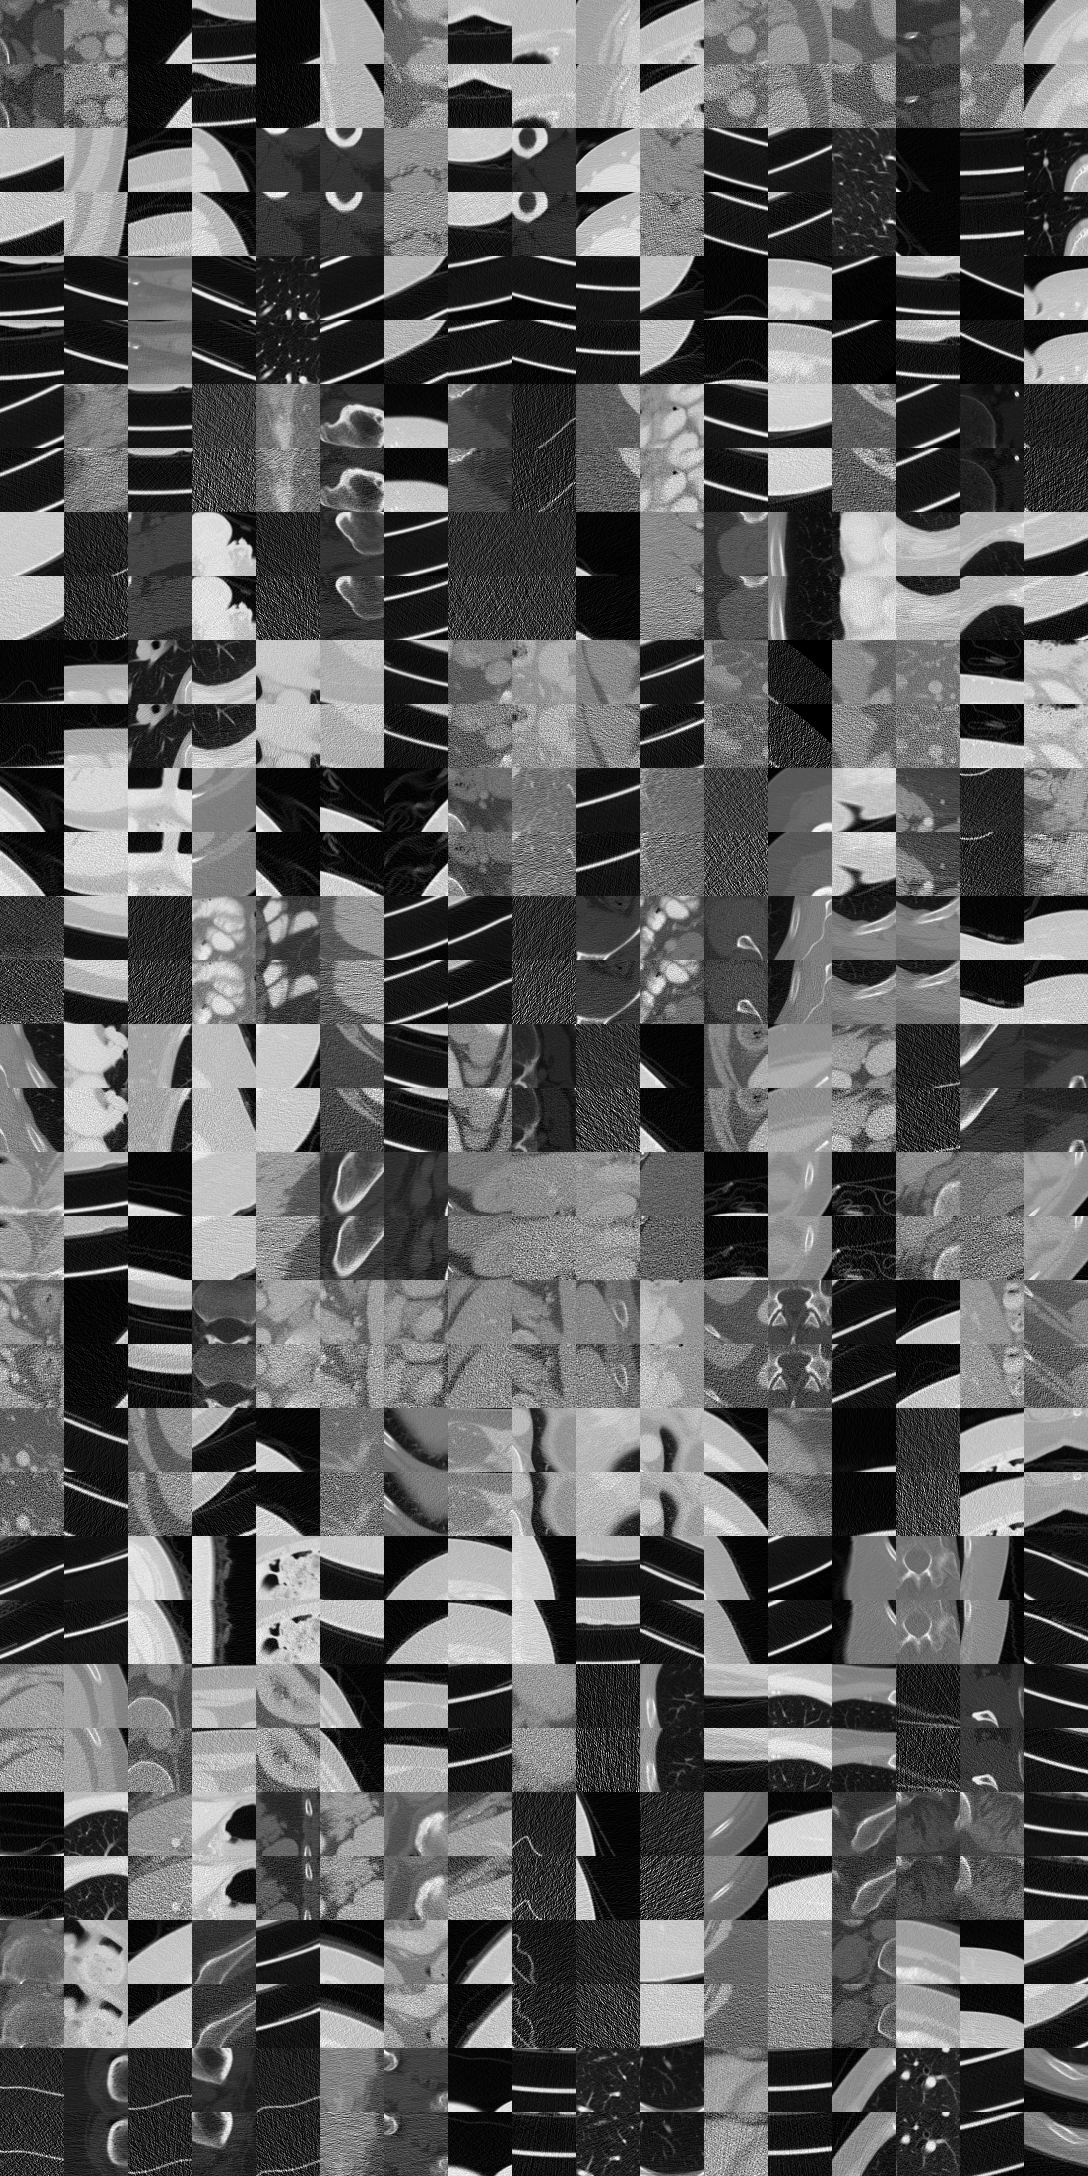

In [14]:
print('All training pairs for a single batch shown below as follows:')
print('routine dose (top) `y`')
print('------------------')
print('low dose (bottom) `x`')
l_images = []
grid_size = 17
N = grid_size**2
for i in range(N):
    image = (normalize(np.concatenate([y.reshape(-1, 64, 64).numpy()[i], x.reshape(-1, 64, 64).numpy()[i]], axis=0))*255).astype('uint8')
    l_images.append(Image.fromarray(image))
pil_grid(l_images, grid_size)

learly the patietnt table was in a lot fof the traini exampsles..

In [15]:
train_noise = x - y

In [16]:
x.dtype, y.dtype, train_noise.dtype

(torch.int16, torch.int16, torch.int16)

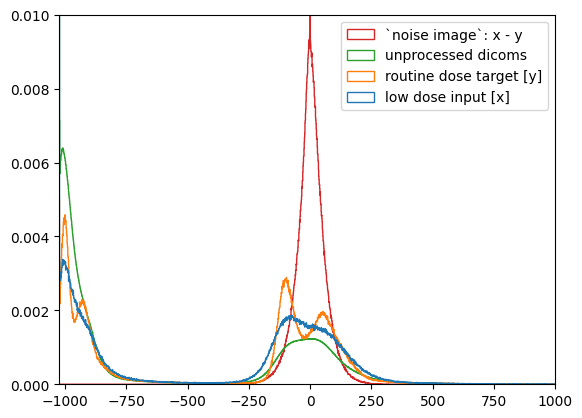

In [17]:
plt.hist([x.ravel(), y.ravel(), image_list.ravel(), train_noise.ravel()], label = ['low dose input [x]', 'routine dose target [y]', 'unprocessed dicoms', '`noise image`: x - y'], bins=4096, density=True, histtype='step')
plt.legend()
plt.ylim([0, 0.01])
plt.xlim([-1024, 1000])
plt.show()

^ This confirms that there was no scaling done to the training data

### Now what does the noise histograms look like and how does this compare to our noise patches? 
Note: Two sets of images amay have the sae histogram statistics but wildly different textures (give exmaple of this, because histograms have no spatial awareness, whereas NPS does)

In [ ]:
noise_patch_dir = Path('/home/brandon.nelson/Dev/PediatricCTSizeAugmentation/noise_patches/patch_size_64x64')
diameters = [112, 131, 151, 185, 216, 292]

noise_files = [noise_patch_dir / f'diameter{d}mm.npy' for d in diameters]
noise_patch_dict = {f.stem: np.load(f)[:100] for f in noise_files}
noise_patches = np.concatenate(list(noise_patch_dict.values()))

In [ ]:
[len(o) for o in noise_patch_dict.values()]

In [ ]:
noise_diam = np.load(noise_patch_dir / 'diameter292mm.npy')
noise_diam.shape

In [ ]:
plt.hist([noise_patch_dict[o].ravel() for o in sorted(noise_patch_dict.keys())], bins=4096, label=list(sorted(noise_patch_dict.keys())), density=True, histtype='step')
plt.legend()

In [ ]:
plt.hist([x.ravel(), y.ravel(), image_list.ravel(), train_noise.ravel(), noise_patch_dict['diameter292mm'].ravel()], label = ['low dose input [x]', 'routine dose target [y]', 'unprocessed dicoms', '`noise image`: x - y', 'noise patches'], bins=4096, density=True, histtype='step')
plt.legend()
plt.ylim([0, 0.01])
plt.xlim([-1024, 1000])
plt.show()

In [ ]:
normalized_patches = {d: noise_patch_dict[d]/noise_patch_dict[d].std()*train_noise.numpy().std() for d in noise_patch_dict}

In [ ]:
plt.hist([train_noise.ravel(), noise_patch_dict['diameter292mm'].ravel(), normalized_patches['diameter292mm'].ravel()], label = ['`noise image`: x - y', 'noise patches', 'renormalized noise patches'], bins=4096, density=True, histtype='step')
plt.legend()
plt.show()

In [ ]:
train_noise.shape

In [ ]:
train_noise.numpy().mean(axis=(0, 1)).shape

In [ ]:
normalized_patches['diameter292mm'].std(), train_noise.numpy().std()

In [ ]:
noise_patch_dict['diameter292mm'].reshape(100, 64, 64, 1).shape, train_noise.reshape(-1, 64, 64, 1).shape

In [ ]:
from skimage.exposure import match_histograms, histogram

input_shape = noise_patch_dict['diameter292mm'].shape

input_images = noise_patch_dict['diameter292mm'].reshape(-1, 1)
ref_images = train_noise.reshape(-1, 1).numpy()

print(input_images.shape, ref_images.shape)

equal_hist_patches = {diam: match_histograms(input_images.reshape(-1, 1), reference=ref_images).reshape(input_shape) for diam, input_images in noise_patch_dict.items()}
[o.shape for o in equal_hist_patches.values()]

In [ ]:
import pandas as pd

def summarize_patches(patch_dicts:list, names:list):
    rows = list(sorted(patch_dicts[0].keys()))
    for measure, measure_name in zip([lambda x: x.mean(), lambda x: x.std()], ['mean', 'std']):
        temp_names = [o + " " + measure_name for o in names]
        if measure_name == 'mean':
            df = pd.DataFrame(data=np.array([[patches[o].mean() for o in rows] for patches in patch_dicts]).T, index=rows, columns=temp_names)
        else:
            df = df.join(pd.DataFrame(data=np.array([[patches[o].std() for o in rows] for patches in patch_dicts]).T, index=rows, columns=temp_names))
    df['training noise mean'] = train_noise.numpy().mean()
    df['training noise std'] = train_noise.numpy().std()
    return df

summarize_patches([noise_patch_dict, normalized_patches, equal_hist_patches], ['Original', 'normalized','hist matched'])

1. It's interesting that a DC component was added in the histogram matching so we remove it and check again.

In [ ]:
equal_hist_patches = {diam: match_histograms(input_images.reshape(-1, 1), reference=ref_images).reshape(input_shape) for diam, input_images in noise_patch_dict.items()}
equal_hist_patches = {diam: p - p.mean() for diam, p in equal_hist_patches.items()}

summarize_patches([noise_patch_dict, normalized_patches, equal_hist_patches], ['Original', 'normalized','hist matched'])

Now we see that the hist matched mean is 0 and has a standard deviation matching the training noise

In [ ]:
plt.hist([train_noise.ravel(), noise_patch_dict['diameter292mm'].ravel(), equal_hist_patches['diameter292mm'].ravel()], label = ['`noise image`: x - y', 'noise patches', 'matched hist noise patches'], bins=4096, density=True, histtype='step')
plt.legend()
plt.show()

In [ ]:
from skimage.exposure import cumulative_distribution

In [ ]:
for dist_type in['pdf', 'cdf']:
    for img, lbl, style in zip([train_noise.numpy().ravel(), noise_patch_dict['diameter292mm'].ravel(), normalized_patches['diameter292mm'].ravel(), equal_hist_patches['diameter292mm'].ravel()], ['`noise image`: x - y', 'noise patches', 'normalized patches', 'matched hist noise patches'], ['red', 'green', 'blue','violet']):
        img = img.astype('int16')
        if dist_type == 'pdf':
            img_hist, hbins = histogram(img)
            plt.plot(hbins, img_hist/ img_hist.max(), color=style, alpha=0.75)
        else:
            cdf, cbins = cumulative_distribution(img)
            plt.plot(cbins, cdf, color=style, label=lbl)
plt.xlim([-200, 200])
plt.legend()
plt.show()

In [ ]:
print(train_noise.numpy().mean(), train_noise.numpy().std())

[equal_hist_patches[d].std() for d in equal_hist_patches]

In [ ]:
[o.std() for o in noise_patch_dict.values()]

In [ ]:
print('original noise patches')
[print(f'{k} mean {v.mean():2.3f} | std {v.std():2.3f}') for k,v in noise_patch_dict.items()]
print('hist equalized noise patches')
[print(f'{k} mean {v.mean():2.3f} | std {v.std():2.3f}') for k,v in equal_hist_patches.items()];

Nwxt look at the noise patches in trhe training set to understand the difference in hist (higher rorder)

In [ ]:
print('All training noise:')
l_images = []
grid_size = 6
N = grid_size**2
for i in range(N):
    image = (normalize(np.concatenate([train_noise.reshape(-1, 64, 64).numpy()[i]], axis=0))*255).astype('uint8')
    l_images.append(Image.fromarray(image))
pil_grid(l_images, grid_size)

In [ ]:
print('All generated noise patches:')
l_images = []
grid_size = len(noise_patch_dict)
N = grid_size**2
for diam in noise_patch_dict:
    print(diam)
    for i in range(grid_size):
        image = (normalize(np.concatenate([noise_patch_dict[diam][i]], axis=0))*255).astype('uint8')
        l_images.append(Image.fromarray(image))
pil_grid(l_images, grid_size)

In [ ]:
print('Histogram matched noise patches:')
l_images = []
grid_size = len(noise_patch_dict)
N = grid_size**2
for diam in noise_patch_dict:
    print(diam)
    for i in range(grid_size):
        image = (normalize(np.concatenate([equal_hist_patches[diam][i]], axis=0))*255).astype('uint8')
        l_images.append(Image.fromarray(image))
pil_grid(l_images, grid_size)

As we saw above these nmoise patches look quite differ ent by row but all have the same histogram

Now look at the frequency components 

In [ ]:
def compute_nps(image):

  if image.ndim == 2:
    image = image[None, :, :]

  if image.ndim == 4:
    image = image[:,:,:,0]

  nsize = image.shape
  nrealization = nsize[0]
  if image.ndim == 3:
    nps = np.zeros((nsize[1],nsize[2]))
    for i in range(nrealization):
      s = np.fft.fftshift(np.fft.fft2(image[i]))
      nps = np.abs(s)**2 + nps
    nps = nps/(nsize[1]*nsize[2])
  else:
    raise ValueError(f'Image of dimension {image.ndim} Not implemented!')
  return nps


def radial_profile(data, center=None):
    center = center or (data.shape[0]/2, data.shape[1]/2)
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

nps = compute_nps(noise_patch_dict['diameter292mm'])
nps_1d = radial_profile(nps)

f, axs = plt.subplots(1,2)
axs[0].imshow(nps)
axs[1].plot(nps_1d)

In [ ]:
f, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 5), dpi=150)
for d, ax in zip(diameters, axs.flatten()):
    patches = noise_patch_dict[f'diameter{d}mm']
    nps = compute_nps(patches)
    ax.imshow(nps)
    ax.axis('off')
    ax.set_title(f'{len(patches)} x {d} mm patch\nstd: {patches.std():3.3f}')

In [ ]:
for d, ax in zip(diameters, axs.flatten()):
    patches = noise_patch_dict[f'diameter{d}mm']
    nps = compute_nps(patches)
    nps_1d = radial_profile(nps)
    plt.plot(nps_1d, label=d)
plt.legend()
plt.show()

In [ ]:
for d, ax in zip(diameters[::2], axs.flatten()):
    patches = noise_patch_dict[f'diameter{d}mm']
    nps = compute_nps(patches)
    nps_1d = radial_profile(nps)
    plt.plot(nps_1d, label=f'{d} mm original')

    patches = equal_hist_patches[f'diameter{d}mm']
    nps = compute_nps(patches)
    nps_1d = radial_profile(nps)
    plt.plot(nps_1d, label=f'{d} mm hist matched', marker='*', linestyle='')
plt.legend()
plt.show()

A few things to note:
1. Since the noise magnitude has been increased, the height was increased, so to better compare, we'll look at the normalized NPS

In [ ]:
for d, ax in zip(diameters[::2], axs.flatten()):
    patches = noise_patch_dict[f'diameter{d}mm'].copy()
    nps = compute_nps(patches)
    nps /= nps.sum() # <--- here
    nps_1d = radial_profile(nps)
    plt.plot(nps_1d, label=f'{d} mm original')

    patches = equal_hist_patches[f'diameter{d}mm'].copy()
    nps = compute_nps(patches)
    nps /= nps.sum() # <--- and here
    nps_1d = radial_profile(nps)
    plt.plot(nps_1d, label=f'{d} mm hist matched', marker='*', linestyle='')
plt.legend()
plt.show()

After making these two adjustments, we can confirm that matching the histograms *did not alter the texture* 

In [ ]:
noise_patches = np.concatenate(list(equal_hist_patches.values()))

In [ ]:
print('All training pairs for a single batch shown below as follows:')
print('routine dose (top) `y`')
print('------------------')
print('low dose (middle) `x`')
print('------------------')
print('noise augmented (bottom) `x`=y + noise_patch`')
l_images = []
grid_size = 17
N = grid_size**2
for i in range(N):
    noise_patch = noise_patches[np.random.choice(list(range(len(noise_patches))))]
    image = (normalize(np.concatenate([y.reshape(-1, 64, 64).numpy()[i], x.reshape(-1, 64, 64).numpy()[i], y.reshape(-1, 64, 64).numpy()[i]+noise_patch], axis=0))*255).astype('uint8')
    l_images.append(Image.fromarray(image))
pil_grid(l_images, grid_size)